<a href="https://colab.research.google.com/github/twyeh/solid-state-physics/blob/main/PythTB_Graphene_%E5%88%86%E6%9E%90%E7%AD%86%E8%A8%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 探討如何使用 PythTB分析石墨烯結構晶體

In [140]:
!pip install pythTB

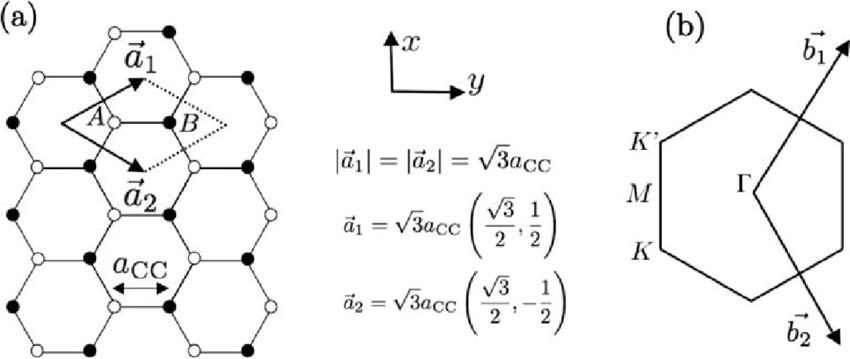
## 步驟一：使用`Lattice` 類建構石墨烯晶格
石墨烯為蜂巢狀二維晶格，屬於正六邊形布拉菲晶格。

1. 基本引數︰碳-碳原子間距$a_{cc}$：約為$1.42 \text{Å}(0.142\text{nm})$。
2. 晶格常數$a$：即原胞向量的長度,$a=\sqrt{3}a_{cc}\approx 2.46\text{Å}$。

###晶格基底的選擇：
一個紅色和一個藍色合在一起就形成了 2 個原子的基底。這樣你就可以想像一個六角晶格，它是一個具有平行四邊形單元（兩個紅色三角形拼在一起）的晶格，具有一定的角度，你在每個頂點上放置一個紅色+藍色（相隔一定距離）的碳基底。

元包的晶格向量:

$$
\mathbf{a}_{1} = \sqrt{3}a (\frac{\sqrt{3}}{2} \hat{x} - \frac{1}{2}\hat{y}), \quad \mathbf{a}_{2} = \sqrt{3}a (\frac{\sqrt{3}}{2} \hat{x} + \frac{1}{2}\hat{y})
$$

根據晶格向量，標定軌道位置 (orbital position) 即碳原子位置

$$
\mathbf{\tau}_{1} = \frac{1}{3}(\mathbf{a}_{1} +  \mathbf{a}_{2})
 \quad \mathbf{\tau}_{2} = \frac{2}{3}( \mathbf{a}_{1} + \mathbf{a}_{2})
$$



In [141]:
from pythtb import Lattice
import numpy as np

In [142]:
lat_vecs = [[3/2, -np.sqrt(3)/2], [3 / 2, +np.sqrt(3) / 2]]
orb_vecs = [[1 / 3, 1 / 3], [2 / 3, 2 / 3]]

In [143]:
lat = Lattice(orb_vecs=orb_vecs, lat_vecs=lat_vecs, periodic_dirs=[0, 1])

In [144]:
print(lat)

----------------------------------------
       Lattice structure report         
----------------------------------------
r-space dimension           = 2
k-space dimension           = 2
periodic directions         = [0, 1]
number of orbitals          = 2

Lattice vectors (Cartesian):
  # 0 ===> [ 1.500, -0.866]
  # 1 ===> [ 1.500,  0.866]
Volume of unit cell (Cartesian) = 2.598 [A^d]

Reciprocal lattice vectors (Cartesian):
  # 0 ===> [ 2.094, -3.628]
  # 1 ===> [ 2.094,  3.628]
Volume of reciprocal unit cell = 15.195 [A^-d]

Orbital vectors (Cartesian):
  # 0 ===> [ 1.000,  0.000]
  # 1 ===> [ 2.000,  0.000]

Orbital vectors (fractional):
  # 0 ===> [ 0.333,  0.333]
  # 1 ===> [ 0.667,  0.667]
----------------------------------------


Let's verigy that the reciprocal lattice vectors satisfy the orthogonality condition with the real-space lattice vectors.

$$\mathbf{a}_{i} \cdot \mathbf{b}_{j} = 2 \pi \delta_{ij}$$

In [145]:
overlap_mat = lat.lat_vecs @ lat.recip_lat_vecs.T
print(overlap_mat / (2 * np.pi))

[[ 1.00000000e+00 -4.79476621e-17]
 [-4.79476621e-17  1.00000000e+00]]


In [146]:
print(lat.recip_volume, lat.cell_volume)

15.195250020704153 2.598076211353316


In [147]:
from pythtb import TBModel, Lattice
import numpy as np
import matplotlib.pyplot as plt

In [148]:
# make two dimensional tight-binding graphene model
my_model = TBModel(lat)

# set model parameters
delta = -0.1
t = -1.0

# set on-site energies
my_model.set_onsite([-delta, delta])
# set hoppings (one for each connected pair of orbitals)
# (amplitude, i, j, [lattice vector to cell containing j])
my_model.set_hop(t, 0, 1, [0, 0])
my_model.set_hop(t, 1, 0, [1, 0])
my_model.set_hop(t, 1, 0, [0, 1])

print(my_model)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 2
k-space dimension           = 2
periodic directions         = [0, 1]
spinful                     = False
number of spin components   = 1
number of electronic states = 2
number of orbitals          = 2

Lattice vectors (Cartesian):
  # 0 ===> [ 1.500, -0.866]
  # 1 ===> [ 1.500,  0.866]
Volume of unit cell (Cartesian) = 2.598 [A^d]

Reciprocal lattice vectors (Cartesian):
  # 0 ===> [ 2.094, -3.628]
  # 1 ===> [ 2.094,  3.628]
Volume of reciprocal unit cell = 15.195 [A^-d]

Orbital vectors (Cartesian):
  # 0 ===> [ 1.000,  0.000]
  # 1 ===> [ 2.000,  0.000]

Orbital vectors (fractional):
  # 0 ===> [ 0.333,  0.333]
  # 1 ===> [ 0.667,  0.667]
----------------------------------------
Site energies:
  < 0 | H | 0 > =  0.100 
  < 1 | H | 1 > = -0.100 
Hoppings:
  < 0 | H | 1  + [ 0.0 ,  0.0 ] > = -1.0000+0.0000j
  < 1 | H | 0  + [ 1.0 , 

## Path in Brillouin zone from `TBModel`

We generate list of k-points following a segmented path in the BZ list of nodes (high-symmetry points) using `TBModel.k_path`.
These high-symmetry points are specified in reduced coordinates: each entry is a list of fractional coordinates with respect to the reciprocal lattice vectors. We choose the nodes:

- $\Gamma$  = `[0, 0]`
- $K$       = `[2/3, 1/3]`
- $M$       = `[1/2, 1/2]`
- $\Gamma$  = `[0, 0]`

Outputs:
- `k_path`: list of interpolated k-points
- `k_dist`: horizontal axis position of each k-point in the list
- `k_node_dist`: horizontal axis position of each original node

In [149]:
k_nodes = [[0, 0], [2 / 3, 1 / 3], [1 / 2, 1 / 2], [0, 0]]
k_node_labels = (r"$\Gamma $", r"$K$", r"$M$", r"$\Gamma $")
nk = 121

k_path, k_dist, k_node_dist = my_model.k_path(k_nodes, nk)

## Band structure

Graphene has a characteristic linear band crossing at the K point in the Brillouin zone, known as a Dirac cone. This results in unique electronic properties, such as high electron mobility and massless charge carriers. The band structure can be calculated using the tight-binding model and visualized along high-symmetry paths in the Brillouin zone.

We diagonalize the Hamiltonian at each k-point to obtain the energy eigenvalues, which represent the allowed energy levels for electrons in the material. Plotting these energy levels against the k-points gives us the band structure of graphene, revealing its electronic properties.

In [150]:
evals = my_model.solve_ham(k_path)

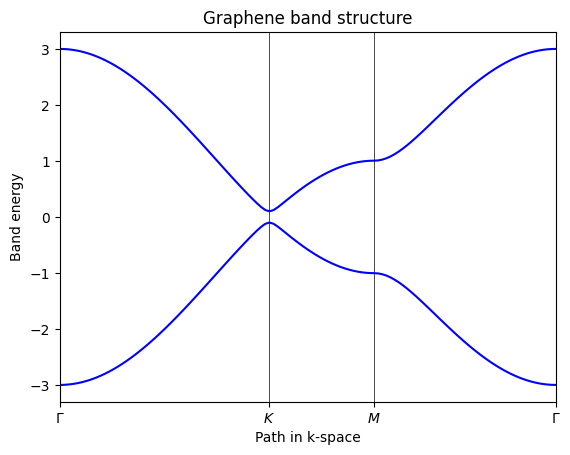

In [151]:
fig, ax = plt.subplots()

ax.set_xlim(k_node_dist[0], k_node_dist[-1])
ax.set_xticks(k_node_dist)
ax.set_xticklabels(k_node_labels)

for n in range(len(k_node_dist)):
    ax.axvline(x=k_node_dist[n], linewidth=0.5, color="k")

ax.set_title("Graphene band structure")
ax.set_xlabel("Path in k-space")
ax.set_ylabel("Band energy")

# plot bands
ax.plot(k_dist, evals, c="b")
plt.show()

Alternatively, we can use the `TBModel.band_structure` method to compute the band structure directly along the specified path without having to generate the k-points separately or specify the matplotlib details. This method takes care of computing the k-points, solving the Hamiltonian, and plotting the results in one step.

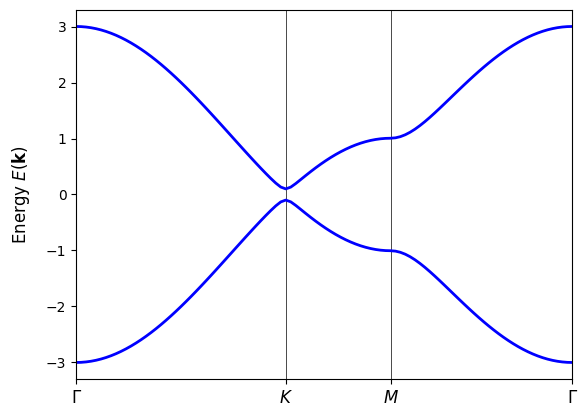

In [152]:
my_model.plot_bands(k_nodes, k_node_labels)
plt.show()

## Circular path around Dirac cone

First we will construct the circular path of k-points around the Dirac cone.

In [153]:
circ_step = 31  # number of steps in the circular path
circ_center = np.array([1 / 3, 2 / 3])  # the K point
circ_radius = 0.1  # the radius of the circular path

# construct k-point coordinate on the path
kpts = []
for i in range(circ_step):
    ang = 2 * np.pi * i / (circ_step - 1)
    kpt = np.array([np.cos(ang) * circ_radius, np.sin(ang) * circ_radius])
    kpt += circ_center
    kpts.append(kpt)
kpts = np.array(kpts)

### `Mesh` class

We will now utilize the `Mesh` class to store the k-points along the path around the Dirac cone.

In this case, we have a one-dimensional k-path in a two-dimensional Brillouin zone, so we must specify `dim_k=2` when initializing the `Mesh` object. We pass a single 'k' to the `axis_types` argument since we only have one k-axis in our mesh.

In [154]:
from pythtb import WFArray, Mesh

In [155]:
mesh = Mesh(["k"], dim_k=2)
mesh.build_custom(kpts)
print(mesh)

Mesh Summary
Type: path
Dimensionality: 2 k-dim(s) + 0 λ-dim(s)
Number of mesh points: 31
Full shape: (31, 2)
k-axes: [Axis(type=k, name=k_0, size=31)]
λ-axes: []
Loops: (axis 0, comp 0, winds_bz=no, closed=yes), (axis 0, comp 1, winds_bz=no, closed=yes)


### `WFArray` class

We now construct a `WFArray` object to hold the wavefunction data for each k-point in the mesh. The `WFArray` class is designed to work seamlessly with the `Mesh` class, allowing us to easily associate wavefunction data with the specific k-points (or parameter points) stored in the `Mesh`.

In [156]:
w_circ = WFArray(my_model.lattice, mesh)

### Berry phase
We can compute the Berry phase along the circular path using the `berry_phase` method of the `WFArray` object. This method takes a list of band indices as input and returns the Berry phase for those bands.

In [157]:
w_circ.solve_model(my_model)

berry_phase_0 = w_circ.berry_phase(0, [0])
berry_phase_1 = w_circ.berry_phase(0, [1])
berry_phase_both = w_circ.berry_phase(0, [0, 1])

print(
    f"Berry phase along circle with radius {circ_radius} and centered at k-point {circ_center}"
)
print(f"for band 0 equals     : {berry_phase_0: .7f}")
print(f"for band 1 equals     : {berry_phase_1: .7f}")
print(f"for both bands equals : {berry_phase_both: .7f}")

Berry phase along circle with radius 0.1 and centered at k-point [0.33333333 0.66666667]
for band 0 equals     :  2.5636831
for band 1 equals     : -2.5636831
for both bands equals :  0.0000000


## Square patch around Dirac cone

Next, we construct a two-dimensional square patch covering the Dirac cone. We will construct the side length of the square patch such that the area of the patch equals the area enclosed by the loop around the Dirac point with radius `circ_radius` constructed above (`square_length` = $\sqrt{\pi \texttt{circ\_radius}^2}$)

In [158]:
square_step = 50
square_center = np.array([1 / 3, 2 / 3])
square_length = np.sqrt(np.pi * circ_radius**2)

all_kpt = np.zeros((square_step, square_step, 2))
for i in range(square_step):
    for j in range(square_step):
        kpt = np.array(
            [
                square_length * (-0.5 + i / (square_step - 1)),
                square_length * (-0.5 + j / (square_step - 1)),
            ]
        )
        kpt += square_center
        all_kpt[i, j, :] = kpt

### `Mesh` class

:::{versionadded} 2.0.0
:::

Again, we add the k-points into the `Mesh` object, but this time by calling the `build_grid` method. In circumstances where we have a regular grid of k-points, this method is particularly useful as it can automatically generate the necessary k-point coordinates based on the specified grid parameters. We can also specify the grid directly by passing the `points` parameter.

:::{warning}
The `points` array must have a shape that corresponds to `shape_k`. For example, if `shape_k` is `(4, 4)`, then `points` should have the shape `(4, 4, 2)` to represent the k-point coordinates in 2D.
:::

In [159]:
mesh = Mesh(["k", "k"])
mesh.build_custom(points=all_kpt)
print(mesh)

Mesh Summary
Type: grid
Dimensionality: 2 k-dim(s) + 0 λ-dim(s)
Number of mesh points: 2500
Full shape: (50, 50, 2)
k-axes: [Axis(type=k, name=k_0, size=50), Axis(type=k, name=k_1, size=50)]
λ-axes: []
Is a torus in k-space (all k-axes wind BZ): no
Loops: None


### `WFArray` class
Now we do the same thing as before to solve the model on these k-points, by calling `solve_k_mesh` on the `WFArray` object.

In [160]:
w_square = WFArray(my_model.lattice, mesh)
w_square.solve_model(my_model)

### Berry flux

Next, we can compute the Berry flux on this square grid of k-points by calling `WFArray.berry_flux`. We pass as arguments the band indices and optionally can specify the plane on which the Berry flux should be computed.

:::{note}
In our case, we have only one plane since the system is two-dimensional and we are interested in the Berry flux in the kx-ky plane.
However, if `plane` is unspecified, the Berry flux will be computed for all available planes, and will be returned with an additional set of two axes corresponding to each dimension in parameter space. Since the Berry flux is an anti-symmetric tensor, the `[0,1]` and `[1,0]` components will be related by a minus sign. So here, we specify the plane so the returned object just gets the (`[0,1]`) component corresponding to $\Omega(\mathbf{k})^{(0,1)}$.
:::

In [161]:
b_flux_0 = w_square.berry_flux(state_idx=[0], plane=(0, 1))
b_flux_1 = w_square.berry_flux(state_idx=[1], plane=(0, 1))
b_flux_both = w_square.berry_flux(state_idx=[0, 1], plane=(0, 1))

print(
    f"Berry flux on square patch with length: {square_length} and centered at k-point: {square_center}"
)
print("for band 0 equals    : ", np.sum(b_flux_0))
print("for band 1 equals    : ", np.sum(b_flux_1))
print("for both bands equals: ", np.sum(b_flux_both))

Berry flux on square patch with length: 0.1772453850905516 and centered at k-point: [0.33333333 0.66666667]
for band 0 equals    :  2.566799155062844
for band 1 equals    :  -2.566799155062845
for both bands equals:  -9.451219036451881e-16


Now we will visualize the Berry flux over the square patch by plotting the individual flux for each plaquette in the grid. We expect to see a characteristic hotspot of Berry curvature centered at the Dirac point.

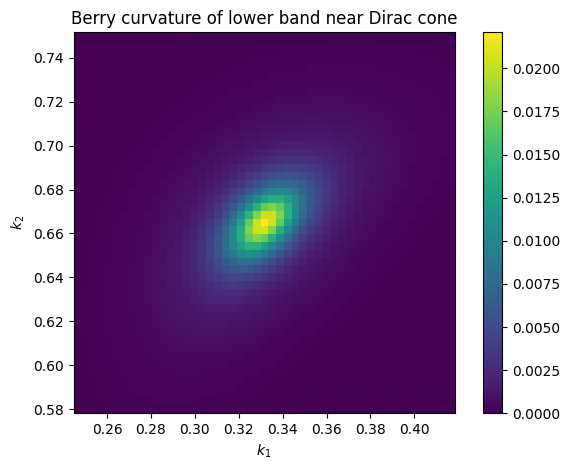

In [162]:
fig, ax = plt.subplots()
img = ax.imshow(
    b_flux_0.real,
    origin="lower",
    extent=(
        all_kpt[0, 0, 0],
        all_kpt[-2, 0, 0],
        all_kpt[0, 0, 1],
        all_kpt[0, -2, 1],
    ),
    vmax=np.amax(b_flux_0.real),
    vmin=0,
)
ax.set_title("Berry curvature of lower band near Dirac cone")
ax.set_xlabel(r"$k_1$")
ax.set_ylabel(r"$k_2$")
plt.colorbar(img)
fig.tight_layout()

Since the model is overall time-reversal symmetric, the total Berry flux over the entire Brillouin zone must be zero. The Berry flux of the second band will be equal in magnitude but opposite in sign to that of the first band.

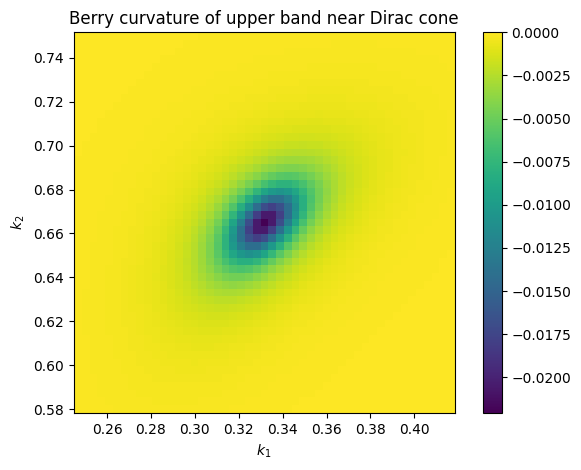

In [163]:
fig, ax = plt.subplots()
img = ax.imshow(
    b_flux_1.real,
    origin="lower",
    extent=(
        all_kpt[0, 0, 0],
        all_kpt[-2, 0, 0],
        all_kpt[0, 0, 1],
        all_kpt[0, -2, 1],
    ),
    vmax=0,
    vmin=np.amin(b_flux_1.real),
)
ax.set_title("Berry curvature of upper band near Dirac cone")
ax.set_xlabel(r"$k_1$")
ax.set_ylabel(r"$k_2$")
plt.colorbar(img)
fig.tight_layout()